In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Dense , Input
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Configuración reproducible
tf.random.set_seed(42)
np.random.seed(42)

# Verificar GPU
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: []


In [14]:
# Cargar datos
X_train = pd.read_csv("./X_train.csv").values
y_train = pd.read_csv("./y_train.csv").values
X_test = pd.read_csv("./X_test.csv").values
y_test = pd.read_csv("./y_test.csv").values

print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")

Train shapes: (900, 1), (900, 1)
Test shapes: (100, 1), (100, 1)


In [15]:
def build_model():

    model = Sequential([
        Input(shape=(1,)),                
        Dense(64, activation='relu' , name="dense_1"),
        Dense(32, activation='relu', name="dense_2"),
        Dense(1, name="output")
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,241 (8.75 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="../models/checkpoint.weights.h5",
    save_weights_only=True,
    monitor='val_mae',
    mode='min',
    save_best_only=True
)

# Entrenamiento
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 59828.2031 - mae: 202.2843 - val_loss: 30069.2695 - val_mae: 142.4503
Epoch 2/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 29601.1445 - mae: 142.0949 - val_loss: 12772.0840 - val_mae: 92.9424
Epoch 3/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10957.0801 - mae: 85.4365 - val_loss: 2082.7295 - val_mae: 38.6045
Epoch 4/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1312.6819 - mae: 29.8404 - val_loss: 263.9814 - val_mae: 13.4215
Epoch 5/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 259.7455 - mae: 13.0602 - val_loss: 260.3747 - val_mae: 13.4949
Epoch 6/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 247.0740 - mae: 12.9833 - val_loss: 256.7411 - val_mae: 13.3133
Epoch 7/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 245.4356 - mae: 12.8881 - val_loss: 255.7674 - val_mae: 13.2955
Epoch 8/150
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 245.0611 - mae: 12.8395 - val_loss: 254.2434 - val_mae: 13.263

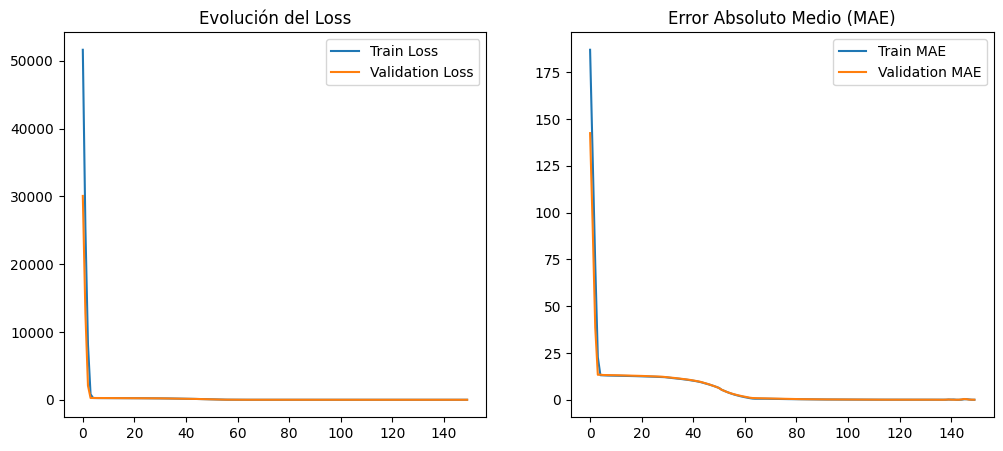


Test MAE: 0.1165 °F


In [17]:
# Gráfico de pérdida
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Evolución del Loss')
plt.legend()

# Gráfico de error absoluto
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Error Absoluto Medio (MAE)')
plt.legend()
plt.show()

# Evaluación cuantitativa
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest MAE: {test_mae:.4f} °F")

In [21]:
# Guardar modelo completo (SavedModel)
#model.save("../models/celsius_to_fahrenheit_model.keras")
model.save("../models/celsius_to_fahrenheit_model.h5")




# Guardar métricas
with open("../models/metrics.json", 'w') as f:
    json.dump({
        'test_mae': float(test_mae),
        'test_loss': float(test_loss)
    }, f)

In [20]:
# Ejemplo de predicción
sample_input = np.array([[0], [345], [-40]]) 
predictions = model.predict(sample_input)

for celsius, pred in zip(sample_input, predictions):
    print(f"{celsius[0]}°C → {pred[0]:.2f}°F (Real: {celsius[0] * 9/5 + 32}°F)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
0°C → 31.12°F (Real: 32.0°F)
345°C → 695.46°F (Real: 653.0°F)
-40°C → -40.04°F (Real: -40.0°F)
